In [278]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [279]:
from pykalman import KalmanFilter

In [280]:
def adf_test_spread(x, y): ## a stationarity test, of the residual of stock prices x and y
    df = pd.DataFrame({'x': x, 'y' : y})
    est = sm.OLS(df.y, df.x) ## OLS = Ordinary Least Squares, for linear regression
    est.fit()
    df['hedge_ratio'] = est.params[0]
    df['intercept'] = est.params[1]
    df['spread'] = df.y - df.x * df.hedge_ratio - df.intercept
    res = ts.adfuller(df['spread'])
    return res[1]

In [281]:
from numpy import log, polyfit, sqrt, std, subtract

In [282]:
def hurst_test(time_ser):
    lags = [i for i in range(2, 200)]
    tau = [(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags] ## Root(Variance) = std_dev
    poly = polyfit(log(lags), log(tau), 1) ## np.polyfit(x, y, deg), linear regression to find slope
    return poly[0] ## Return value is an array of coeffecients in descending order of powers, poly[0] is the slope

In [283]:
def half_life_spread(x):
    
    x_lag = x.shift(1)
    x_lag.iloc[0] = x_lag.iloc[1]
    diff = x - x_lag
    diff.iloc[0] = diff.iloc[1]
    
    x_lag_2 = sm.add_constant(x_lag)
    est = sm.OLS(diff, x_lag_2)
    res = est.fit()

    half_life = int(round(-np.log(2) / res.params[1],0))
    if half_life <= 0:
        half_life = 1
    return half_life

In [284]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [285]:
def KF_linear_regression(x, y):
    """Uses a Kalman Filter to determine the linear regression parameters for stocks x and y"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    ## alpha is intercept, beta is the slope

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y (obs) is 1-dimensional, (beta, alpha) (state) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance = np.ones((2, 2)),
                      transition_matrices = np.eye(2), ## priori params = previous_day_params
                      observation_matrices = obs_mat, ## H of each iteration of the kf algo ** (the observation matrix is not static)
                      observation_covariance = 2, ## 2
                      transition_covariance = trans_cov)
    
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [286]:
def backtest(x, y, allowed_drawdown = 0.05, stop_loss = 0.05):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))

    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept

    halflife = half_life_spread(df1['spread'])

    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 1
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    

    df1['drawdown'] = ffn.to_drawdown_series(df1['cum rets'])
    idx = (df1['drawdown'] < - allowed_drawdown) | (df1['cum rets'] < 1 - stop_loss)
    
    first_idx = idx.idxmax() if idx.any() else None

    if first_idx is not None:
        df1.loc[first_idx:, 'cum rets'] = np.nan
        df1.loc[first_idx:, 'port_rets'] = 0

    df1['cum rets'] = df1['cum rets'].fillna(method='pad')

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe


In [287]:
def find_coint_pairs(df, critical_val = 0.05):
    n = df.shape[1] ## Number of different stocks
    p_value_mat = np.zeros((n, n))

    stocks = df.keys()
    feasible_pairs = []
    for i in range(0, n):
        s1 = df[stocks[i]]
        for j in range(i + 1, n):
            s2 = df[stocks[j]]
            
            p_val = (ts.coint(s1, s2))[1]

            p_value_mat[i, j] = p_val
            if p_val < critical_val: ## The pair is cointegrated
                row = [stocks[i], stocks[j], p_val]
                feasible_pairs.append(row)
    feasible_pairs = pd.DataFrame(feasible_pairs, columns = ['S1', 'S2', 'Pvalue'])
    return p_value_mat, feasible_pairs

In [288]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [289]:
start = datetime(2022, 1, 1)
end = datetime(2024, 12, 23)

it_tickers = [
    "TCS.NS", "INFY.NS", "WIPRO.NS", "HCLTECH.NS", "TECHM.NS",
    "LTIM.NS", "COFORGE.NS", "MPHASIS.NS", "PERSISTENT.NS"
]


df = yf.download(it_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)
df.to_csv('it_train.csv')

[*********************100%***********************]  9 of 9 completed


In [290]:
start = datetime(2022, 1, 1)
end = datetime(2024, 12, 23)

it_tickers = [
    "TCS.NS", "INFY.NS", "WIPRO.NS", "HCLTECH.NS", "TECHM.NS",
    "LTIM.NS", "COFORGE.NS", "MPHASIS.NS", "PERSISTENT.NS"
]


df = yf.download(it_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)
df.to_csv('it_train.csv')

[*********************100%***********************]  9 of 9 completed


In [291]:
pharma_tickers = [
    "SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS", "DIVISLAB.NS",
    "AUROPHARMA.NS", "BIOCON.NS", "LUPIN.NS", "TORNTPHARM.NS",
    "ZYDUSLIFE.NS", "GLENMARK.NS"
]


start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)
df = yf.download(pharma_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)
df.to_csv('pharma_train.csv')

[*********************100%***********************]  10 of 10 completed


In [292]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']
df = yf.download(bank_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)
df.to_csv('bank_train.csv')

[*********************100%***********************]  8 of 8 completed


In [293]:
from datetime import time, timedelta
from dateutil.relativedelta import relativedelta

In [294]:
def backtest2(x, y, allowed_drawdown = 0.05, stop_loss = 0.05):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))
    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept
    halflife = half_life_spread(df1['spread'])
    meanSpread = df1.spread.rolling(window= 1 * halflife).mean()
    stdSpread = df1.spread.rolling(window= 1 * halflife).std()
    
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    entryZscore = 1
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & ( df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1 ## num units long updated for the indices where df1['long entry'] is true
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad') ## each NaN filled with the prev non-NaN value


    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) <  entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & ( df1.zScore.shift(1) >  exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 ## num units short updated for the indices where df1['short entry'] is true
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad') ## each NaN filled with the prev non-NaN value

    df1['action'] = 0
    df1.loc[df1['short entry'], 'action'] = -1
    df1.loc[df1['short exit'] & (df1['num units short'].shift(1) < 0), 'action'] = 1
    df1.loc[df1['long exit'] & (df1['num units short'].shift(1) > 0), 'action'] = -1
    df1.loc[df1['long entry'], 'action'] = 1

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread_pct_chg'] = df1.spread.diff()/df1.spread
    df1['port rets'] = df1['spread_pct_chg'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    df1['drawdown'] = ffn.to_drawdown_series(df1['cum rets'])
    idx = (df1['drawdown'] < - allowed_drawdown) | (df1['cum rets'] < 1 - stop_loss)
    
    first_idx = idx.idxmax() if idx.any() else None

    if first_idx is not None:
        df1.loc[first_idx:, 'cum rets'] = np.nan
        df1.loc[first_idx:, 'port_rets'] = 0

    df1['cum rets'] = df1['cum rets'].fillna(method='pad')

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe, df1['action'], df1['spread'], df1['hr'], df1['y'], df1['x']


In [295]:
def volatility_pair(y, x):
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KF_linear_regression(KF_Avg(x), KF_Avg(y))
    df1['hr'] = state_means[:,0] ## The hedge ratio
    df1['intercept'] = state_means[:, 1]
    df1['spread'] = df1.y - (df1.x * df1.hr) ##- df1.intercept
    
    df1['spread_change'] = df1['spread'].diff()
    spread_pct_chg = df1['spread_change']/df1['spread']
    return spread_pct_chg.std()

In [296]:
def tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol, revise_time = 1):
    start_check = start_date
    end_check = start_check + relativedelta(months=months_check_vol)

    results_dict_list = []

    while end_check <= end_date:
        print(start_check)
        _, poss_pairs = find_coint_pairs(df.loc[start_check: end_check])
        try:
            for pair in poss_pairs.values:
                res = backtest2(df.loc[end_check : end_check + relativedelta(months = revise_time)][pair[0]]
                            , df.loc[end_check : end_check + relativedelta(months = revise_time)][pair[1]],
                            allowed_drawdown= allowed_drawdown, stop_loss=stop_loss)
                vol = volatility_pair(df.loc[end_check - relativedelta(months = 1): end_check][pair[0] ]
                            , df.loc[end_check - relativedelta(months = 1): end_check ][pair[1] ])
                res_dict = {'pair' : pair[0:2], 'sharpe' : res[1], 'returns' : res[0], 'volatility' : vol, 'spread' : res[3], 'trade_action' : res[2]}
                res_dict['hr'] = res[4]
                res_dict['s1'] = res[5]
                res_dict['s2'] = res[6]
                results_dict_list.append(res_dict)
            start_check += relativedelta(months = revise_time)
            end_check = start_check + relativedelta(months=months_check_vol)
        except ValueError as e:
            break
    
    return results_dict_list

In [297]:
def trade_plotter(res):
    for r in res:
        r['returns'].plot()
    plt.ylabel('Return (Per position during active period)')

In [298]:
def res_summary(res):
    prof_count = 0
    prof = 0
    loss_count = 0
    loss = 0
    for t in res:
        
        x = t['returns'][-1] - 1
        vol = t['volatility']
        x = 10000 * x/vol
        if x > 0:
            prof_count += 1
            prof += x
        elif x < 0:
            loss_count += 1
            loss += x
    print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
    print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count if loss_count else 0}')
    print(f'No. of positions with no-change/no trading opportunities: {len(res) - prof_count - loss_count}')
    print(f'Net PnL = {prof + loss}')

In [299]:
start_date = datetime(2022, 7, 1)
end_date = datetime(2025, 1, 1)
allowed_drawdown = 0.05
stop_loss = 0.1
months_check_vol = 6

In [300]:
df = pd.read_csv('bank_train.csv', parse_dates=True, index_col='Date')

In [301]:
res_bank_1_mth_pos = tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol)

2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00


In [302]:
def trade_indicator(res_dic_list, plot_all = False):
    x = 1 if plot_all else 5
    res_dic_list = [r for r in res_dic_list if r['returns'][-1] != 1]
    for i in range(len(res_dic_list)):
        if(i % x == 0):
            spread = res_dic_list[i]['spread']
            spread = spread/spread.mean()
            action = res_dic_list[i]['trade_action']
            ret = res_dic_list[i]['returns']
            if ret[-1] != 1:
                
                # action.plot()
                colors = np.full(len(action), 'black', dtype=object)
                colors[action == 1] = 'green'
                colors[action == -1] = 'red'
                colors[abs(action) == 2] = 'blue'
                tp = ret.index
                for j in range(len(spread) - 1):  # Iterate through segments
                    plt.plot([tp[j], tp[j + 1]],[spread[j], spread[j + 1]], color=colors[j], linewidth=1) # `s` sets marker size
                ret.plot()
            # Add title with dynamic pair and returns information
                plt.title(f"{res_dic_list[i]['pair']} : {res_dic_list[i]['returns'].index[0]}")
                plt.legend(['Spread with Trading Calls', 'Return'])
                plt.figure()

In [303]:
def spreadPriceTradePlot(res_dic_list, plot_all = False):
    x = 1 if plot_all else 5
    res_dic_list = [r for r in res_dic_list if r['returns'][-1] != 1]
    for i in range(len(res_dic_list)):
        if(i % x == 0):
            spread = res_dic_list[i]['spread']
            spread = spread/spread.mean()
            action = res_dic_list[i]['trade_action']
            ret = res_dic_list[i]['returns']
            s1 = res_dic_list[i]['s1']
            s2 = res_dic_list[i]['s2']
            hr = res_dic_list[i]['hr']
            if ret[-1] != 1:
                
                # action.plot()
                colors_s1 = np.full(len(action), 'grey', dtype=object)
                colors_s1[action == 1] = 'green'
                colors_s1[action == -1] = 'red'
                colors_s1[abs(action) == 2] = 'blue'
                colors_s2 = np.full(len(action), 'lightblue', dtype=object)
                colors_s2[action == 1] = 'red'
                colors_s2[action == -1] = 'green'
                colors_s2[abs(action) == 2] = 'blue'
                tp = ret.index
                for j in range(len(spread) - 1):  # Iterate through segments
                    # plt.plot([tp[j], tp[j + 1]],[spread[j], spread[j + 1]], color=colors[j], linewidth=1) # `s` sets marker size
                    plt.plot([tp[j], tp[j + 1]],[s1[j], s1[j + 1]], color=colors_s1[j], linewidth=1.5) # `s` sets marker size
                    plt.plot([tp[j], tp[j + 1]],[s2[j], s2[j + 1]], color=colors_s2[j], linewidth=1.5) # `s` sets marker size
                    # plt.plot([tp[j], tp[j + 1]],[hr[j], hr[j + 1]], color=colors[j], linewidth=1)
                # ret.plot()
            # Add title with dynamic pair and returns information
                plt.title(f"{res_dic_list[i]['pair']} : {res_dic_list[i]['returns'].index[0]}")
                plt.legend([f'{res_dic_list[i]['pair'][1]}', f'{res_dic_list[i]['pair'][0]}'])
                plt.figure()

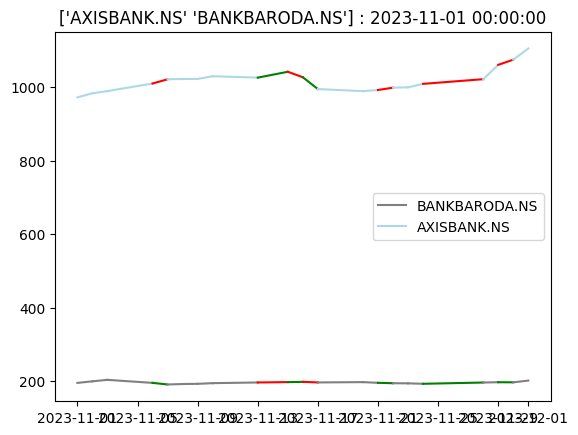

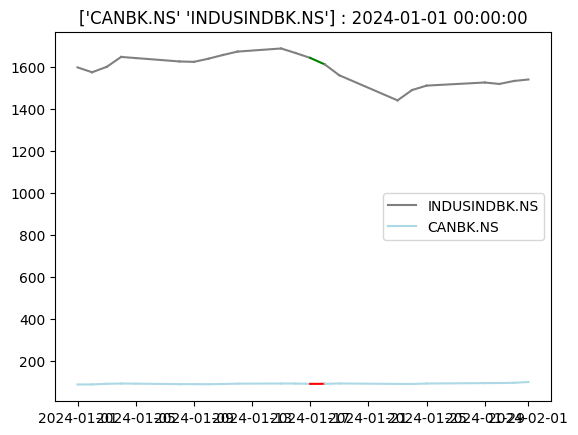

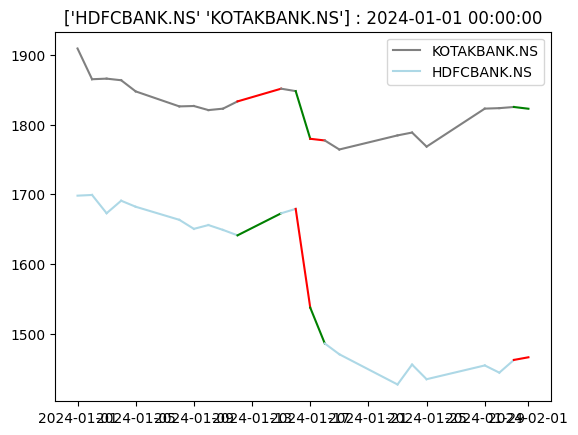

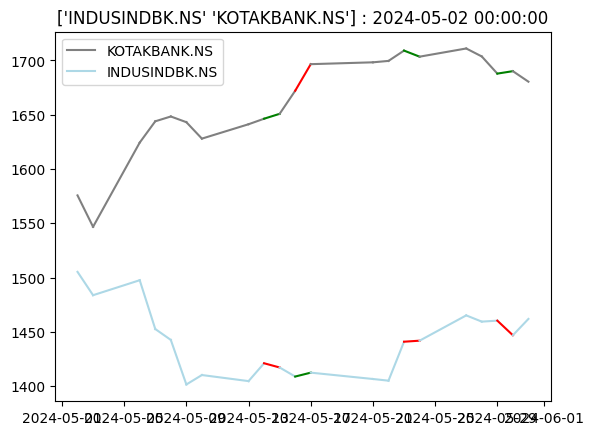

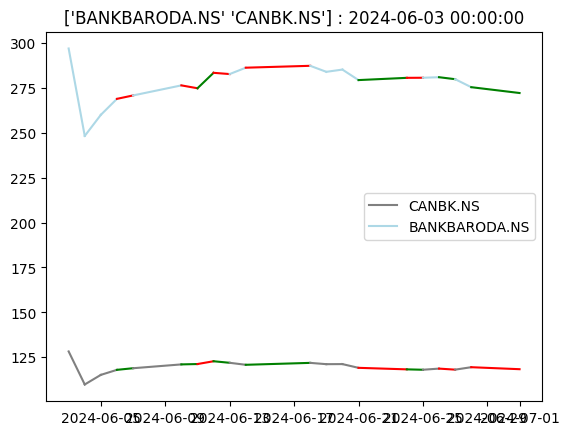

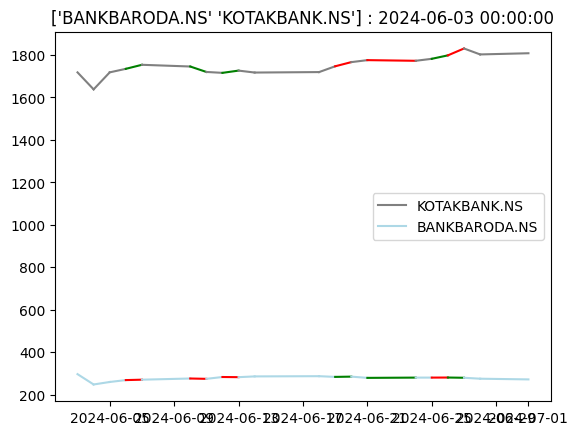

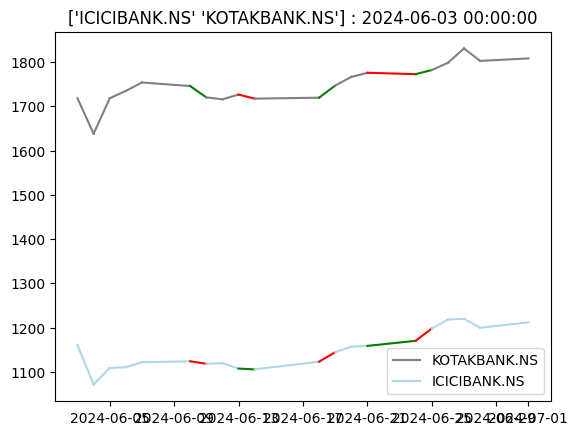

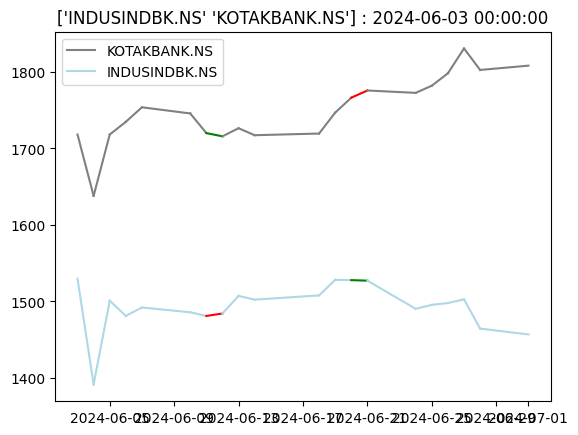

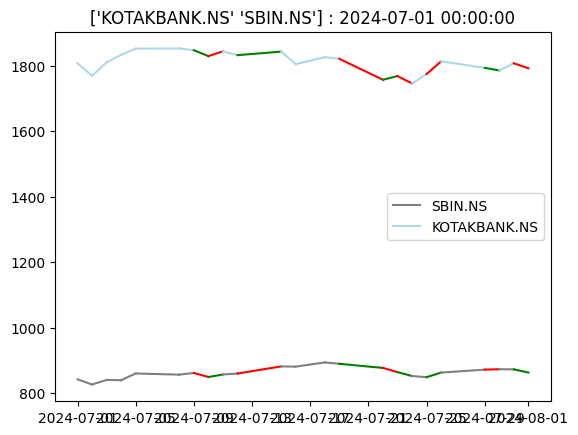

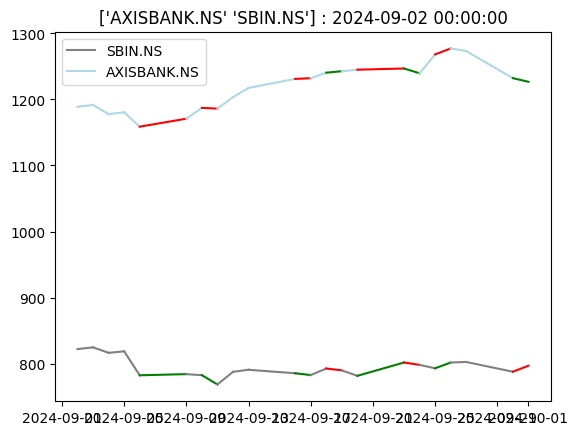

<Figure size 640x480 with 0 Axes>

In [304]:
spreadPriceTradePlot(res_bank_1_mth_pos, plot_all=True)

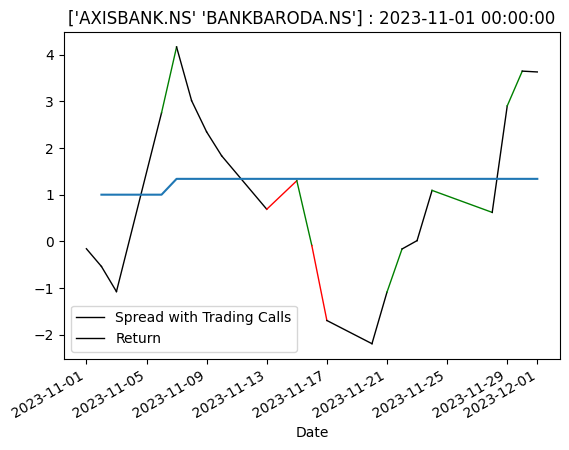

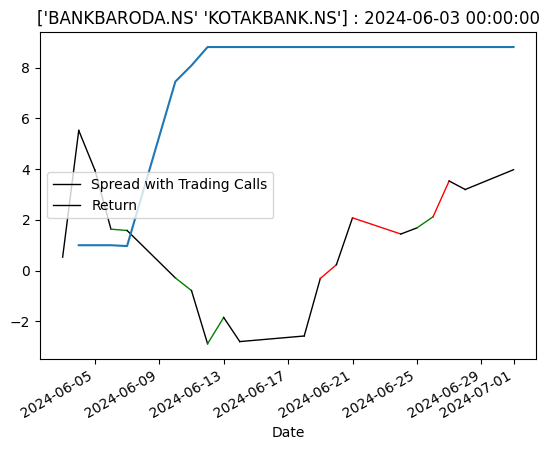

<Figure size 640x480 with 0 Axes>

In [305]:
trade_indicator(res_bank_1_mth_pos)

In [306]:
def netPNLPlotter(res_dict_list):
    big_res_ser = pd.Series()
    money_inv = 0
    for r in res_dict_list:
        vol = r['volatility']
        money_inv += 10000/vol
        tp = (10000/vol * (r['returns']-1)).diff()
        tp[0] = 0
        big_res_ser = big_res_ser.add(tp, fill_value=0)
    port_ret = big_res_ser.cumsum()
    port_ret.plot()
    # print(port_ret)
    # print(port_ret.iloc[-1])
    plt.title('Net PNL')

In [307]:
def drawdownPlotter(res_dict_list):
    big_res_ser = pd.Series()
    money_inv = 0
    for r in res_dict_list:
        vol = r['volatility']
        money_inv += 10000/vol
        tp = (10000/vol * (r['returns'])).diff()
        tp[0] = 0
        big_res_ser = big_res_ser.add(tp, fill_value=0)
    port_ret = big_res_ser.cumsum()
    ffn.to_drawdown_series(port_ret).plot()
    plt.title('Drawdown')

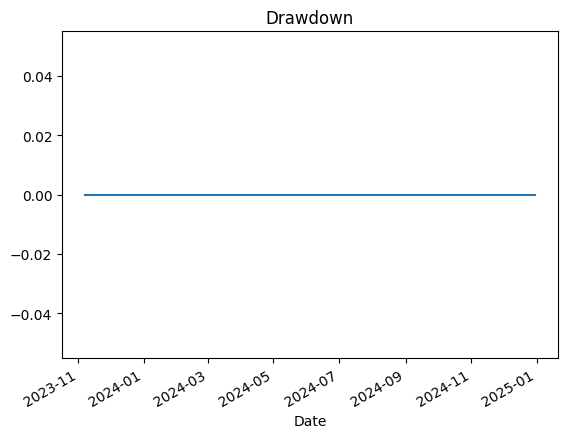

In [308]:
drawdownPlotter(res_bank_1_mth_pos)

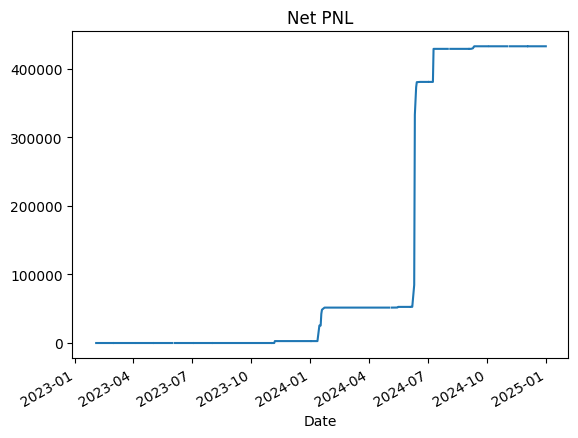

In [309]:
netPNLPlotter(res_bank_1_mth_pos)

In [310]:
def monthlyInvAndPnL(res_dict_list):
    monthly_ret = {}
    monthly_investment = {}
    for i in res_dict_list:
        vol = i['volatility']
        try:
            monthly_ret[str(i['returns'].index[0].date())] += 10000 * (i['returns'][-1]-1)/vol
            monthly_investment[str(i['returns'].index[0].date())] += 10000/vol
        except:
            monthly_ret[str(i['returns'].index[0].date())] = 10000 * (i['returns'][-1]-1)/vol
            monthly_investment[str(i['returns'].index[0].date())] = 10000/vol
    return monthly_investment, monthly_ret
    

In [311]:
monthly_investment, monthly_ret = monthlyInvAndPnL(res_bank_1_mth_pos)

No. of profitable positions: 10, avg_profit = 43250.179717094696
No. of loss-making positions: 0, avg_loss = 0
No. of positions with no-change/no trading opportunities: 34
Net PnL = 432501.79717094696


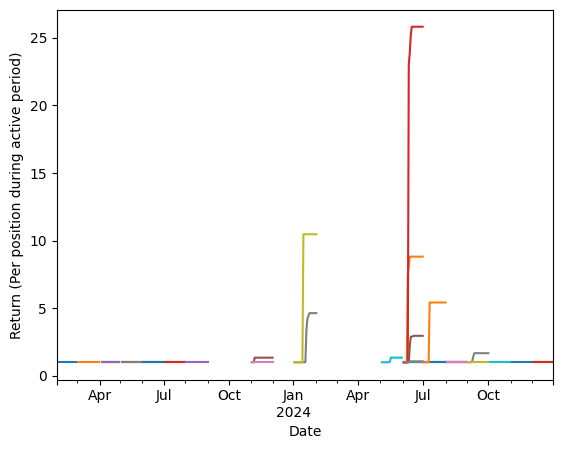

In [312]:
res_summary(res_bank_1_mth_pos)
trade_plotter(res_bank_1_mth_pos)

In [313]:
res_bank_2_mth_pos = tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol, revise_time= 2)

2022-07-01 00:00:00
2022-09-01 00:00:00
2022-11-01 00:00:00
2023-01-01 00:00:00
2023-03-01 00:00:00
2023-05-01 00:00:00
2023-07-01 00:00:00
2023-09-01 00:00:00
2023-11-01 00:00:00
2024-01-01 00:00:00
2024-03-01 00:00:00
2024-05-01 00:00:00
2024-07-01 00:00:00


No. of profitable positions: 8, avg_profit = 13803.609299283746
No. of loss-making positions: 1, avg_loss = -210.35985156431457
No. of positions with no-change/no trading opportunities: 10
Net PnL = 110218.51454270566


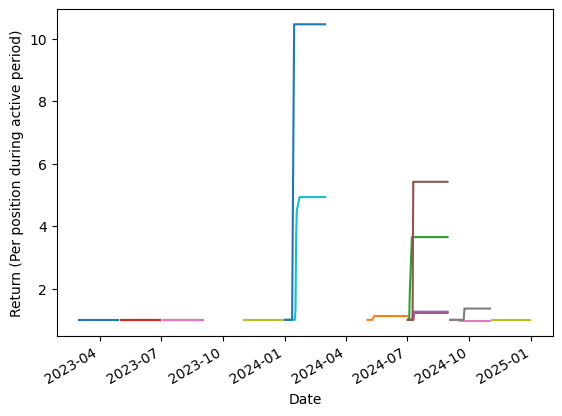

In [314]:
res_summary(res_bank_2_mth_pos)
trade_plotter(res_bank_2_mth_pos)

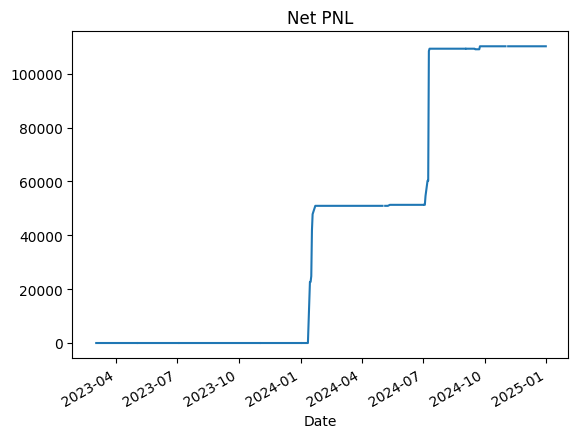

In [315]:
netPNLPlotter(res_bank_2_mth_pos)

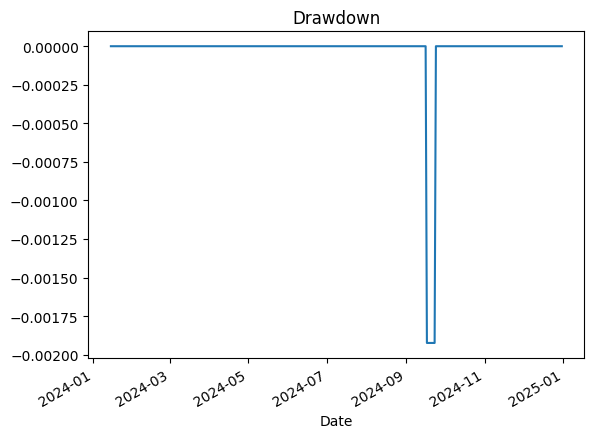

In [316]:
drawdownPlotter(res_bank_2_mth_pos)

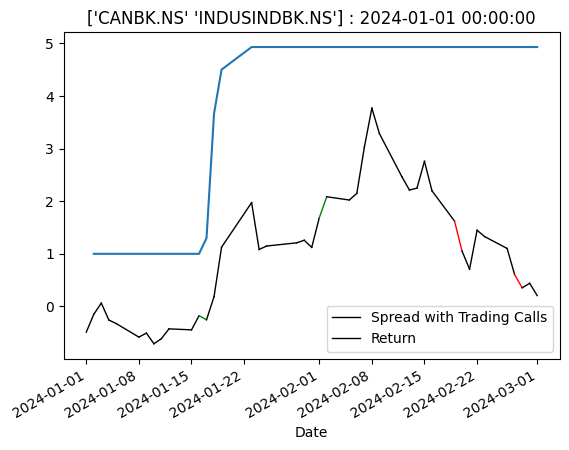

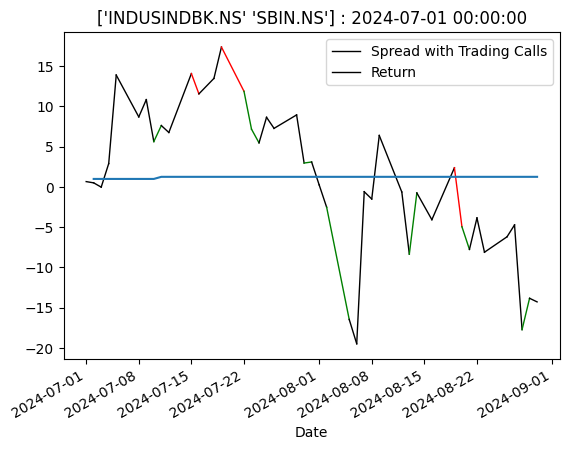

<Figure size 640x480 with 0 Axes>

In [317]:
trade_indicator(res_bank_2_mth_pos)

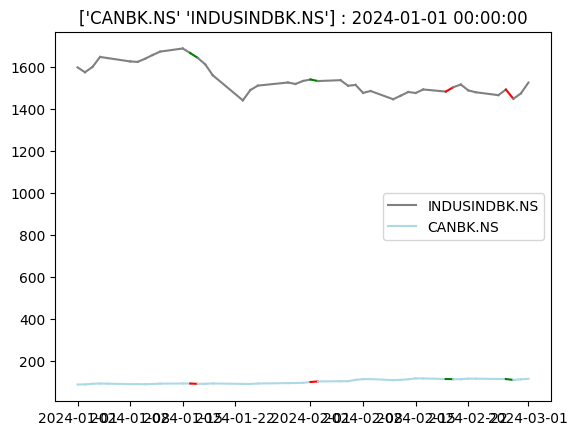

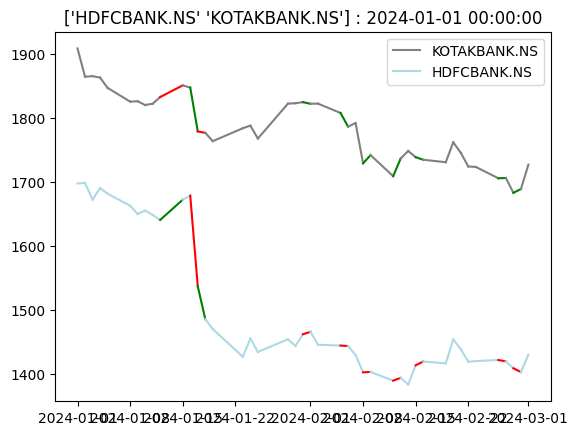

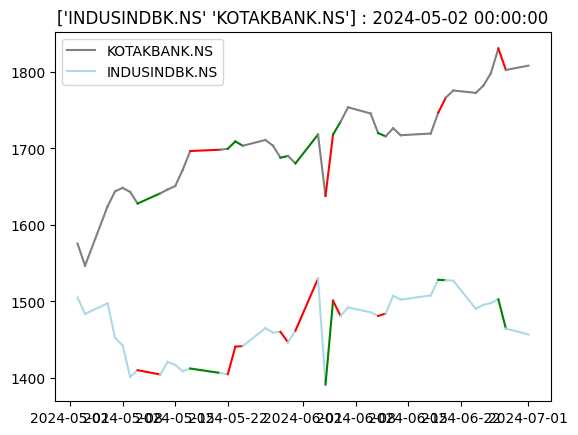

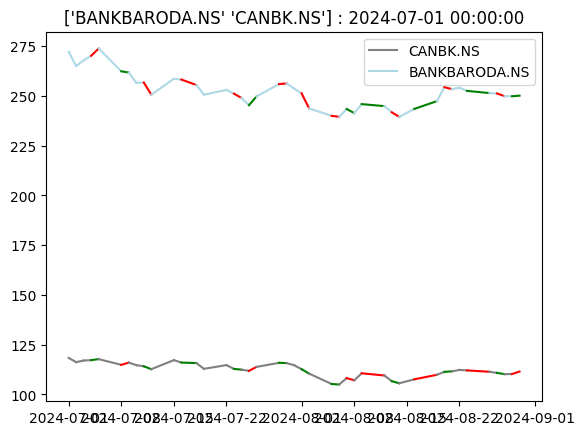

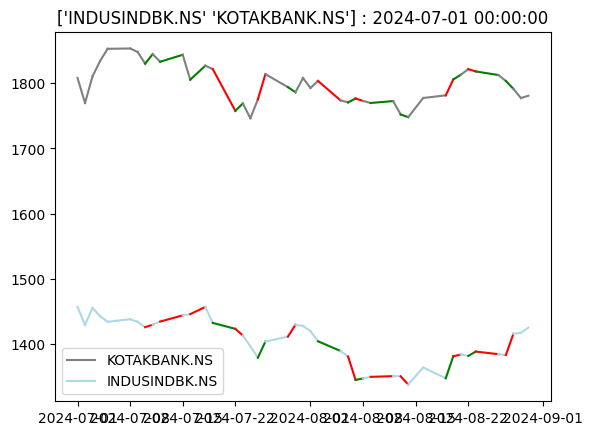

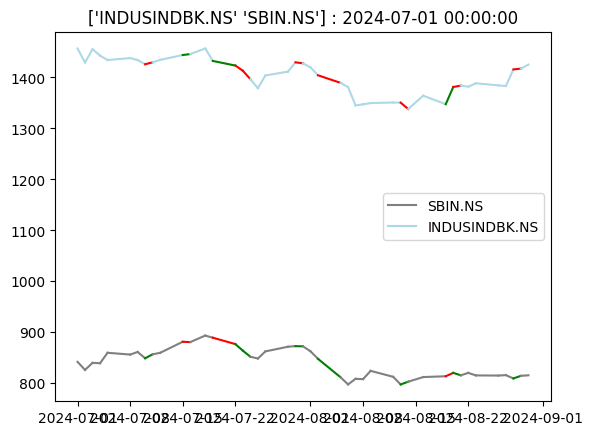

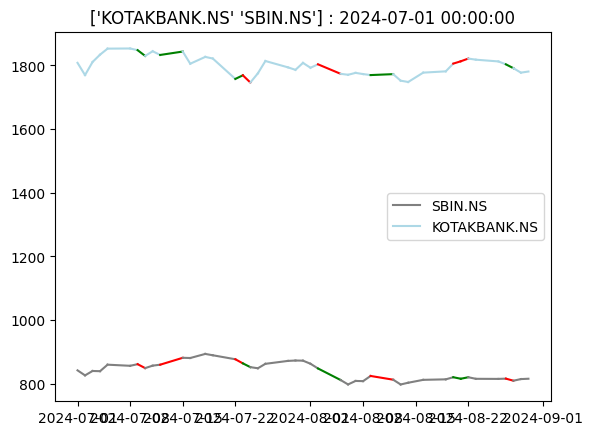

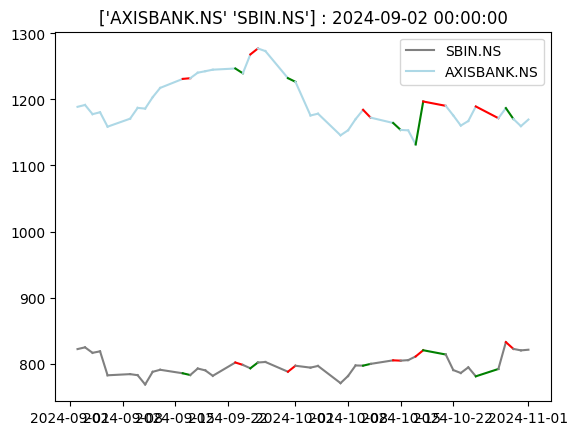

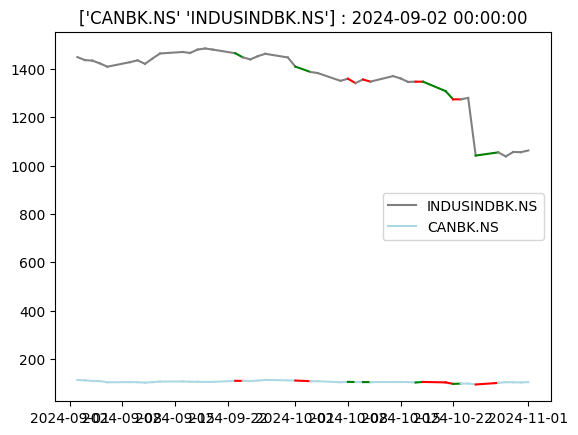

<Figure size 640x480 with 0 Axes>

In [318]:
spreadPriceTradePlot(res_bank_2_mth_pos, plot_all=True)

In [319]:
res_bank_3_mth_pos = tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol, revise_time= 3)

2022-07-01 00:00:00
2022-10-01 00:00:00
2023-01-01 00:00:00
2023-04-01 00:00:00
2023-07-01 00:00:00
2023-10-01 00:00:00
2024-01-01 00:00:00
2024-04-01 00:00:00
2024-07-01 00:00:00


No. of profitable positions: 9, avg_profit = 11485.141013471677
No. of loss-making positions: 0, avg_loss = 0
No. of positions with no-change/no trading opportunities: 4
Net PnL = 103366.26912124509


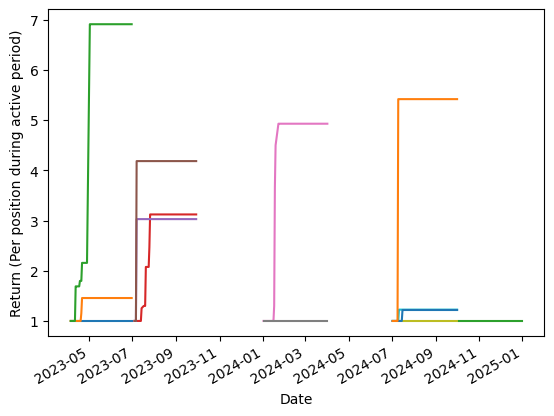

In [320]:
res_summary(res_bank_3_mth_pos)
trade_plotter(res_bank_3_mth_pos)

In [321]:
monthlyInvAndPnL(res_bank_3_mth_pos)

({'2023-04-03': 6877.310848008428,
  '2023-07-03': 3572.793012092183,
  '2024-01-01': 9585.357277320625,
  '2024-07-01': 18007.70375668323,
  '2024-10-01': 3811.681009795634},
 {'2023-04-03': 17506.92463114037,
  '2023-07-03': 8590.46043262895,
  '2024-01-01': 28265.73954214841,
  '2024-07-01': 49003.14451532736,
  '2024-10-01': 0.0})

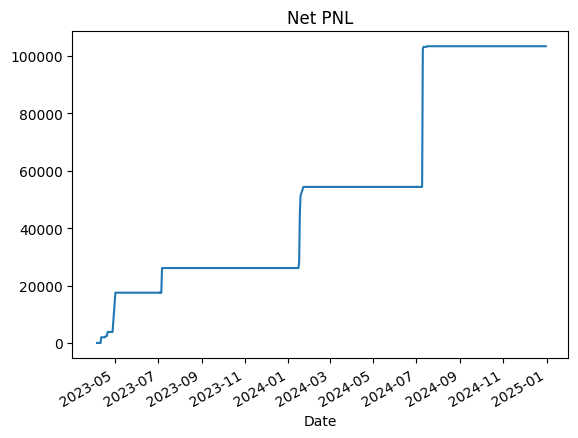

In [322]:
netPNLPlotter(res_bank_3_mth_pos)

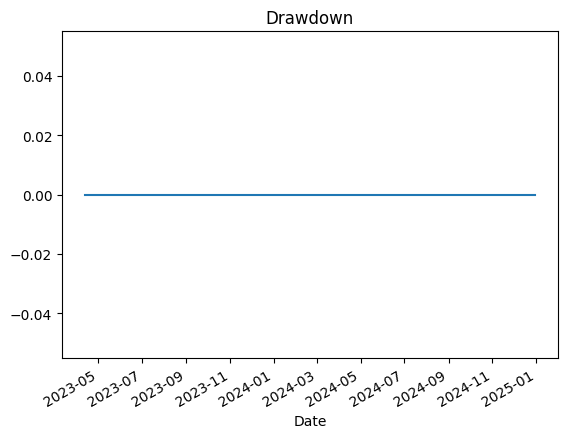

In [ ]:
drawdownPlotter(res_bank_3_mth_pos)

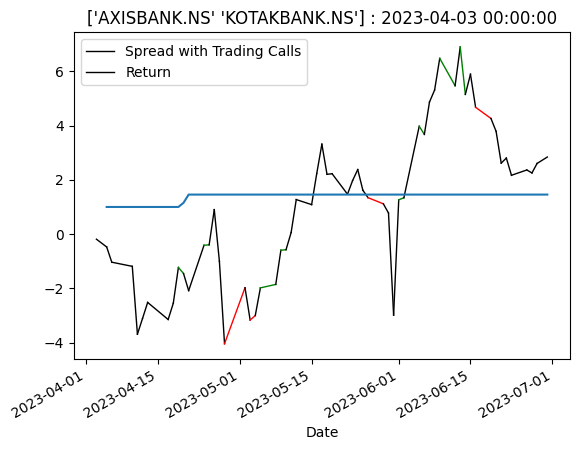

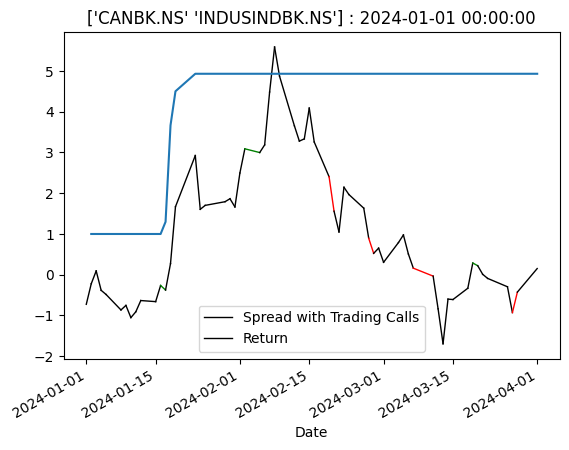

<Figure size 640x480 with 0 Axes>

In [324]:
trade_indicator(res_bank_3_mth_pos)

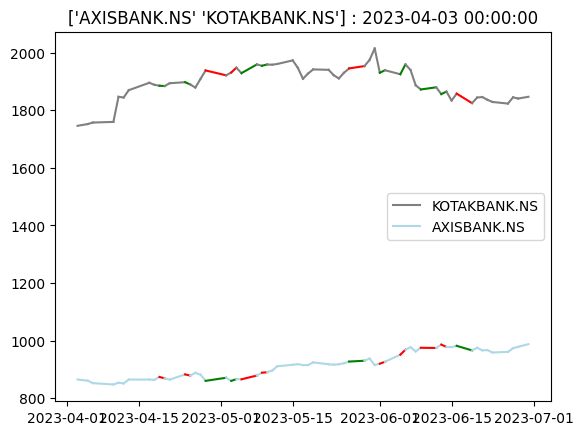

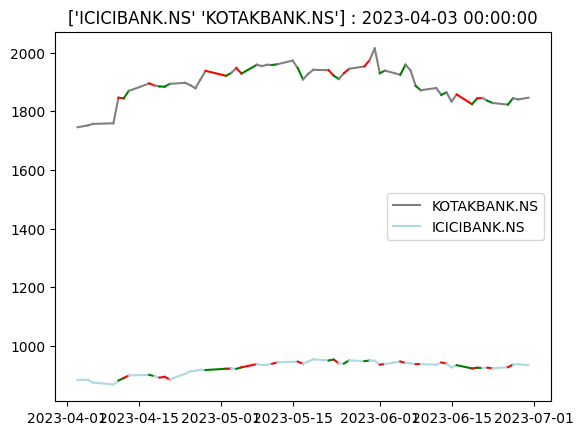

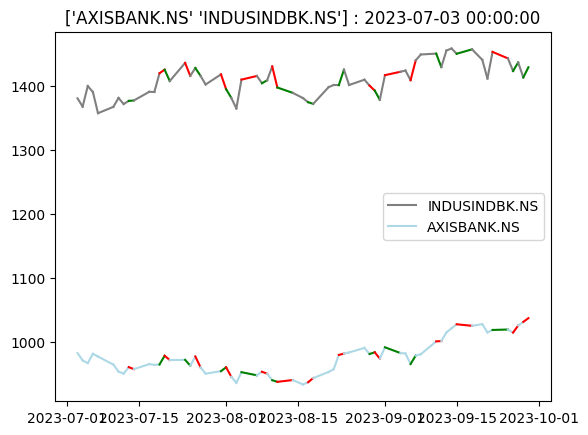

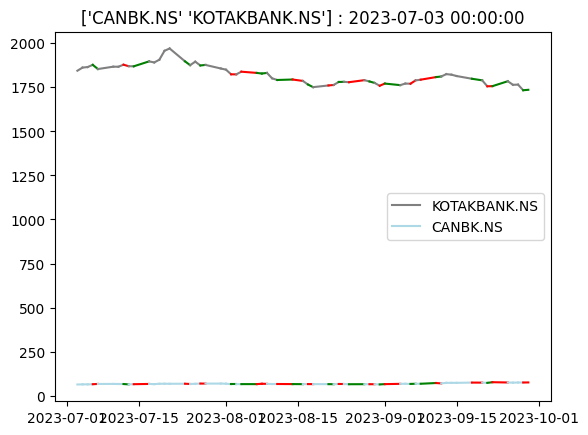

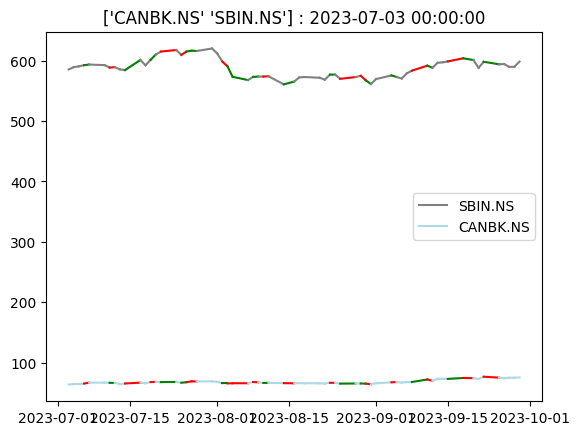

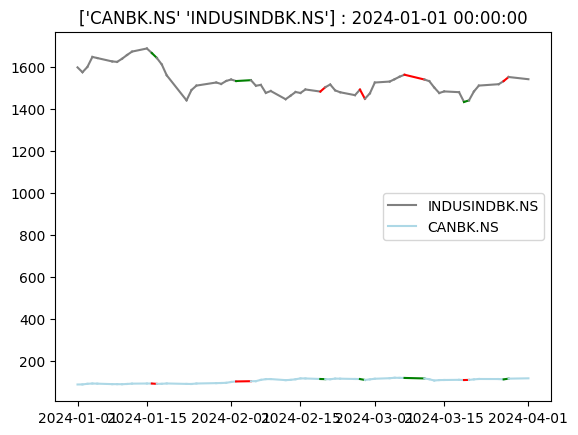

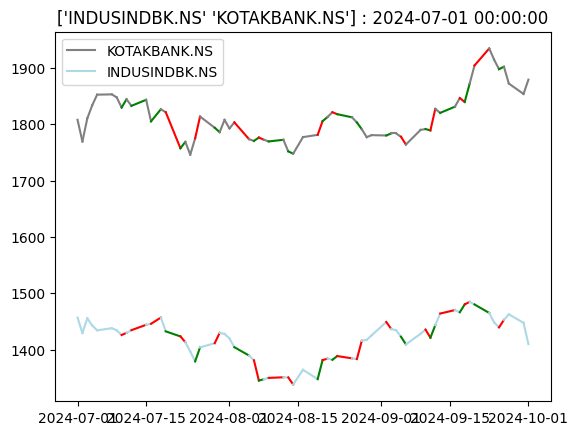

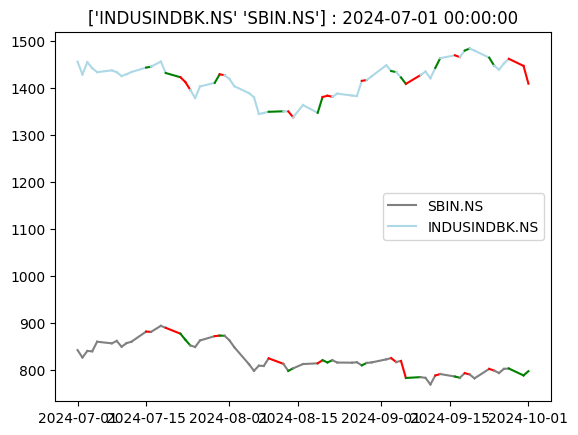

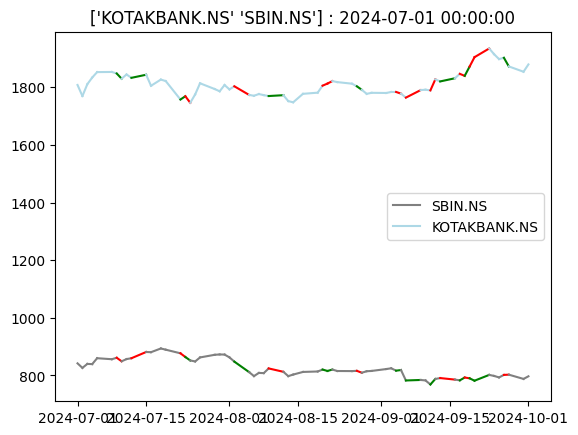

<Figure size 640x480 with 0 Axes>

In [325]:
spreadPriceTradePlot(res_bank_3_mth_pos, plot_all=True)

In [326]:
df = pd.read_csv('it_train.csv', parse_dates=True, index_col='Date')

In [327]:
res_it = tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol)

2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00


No. of profitable positions: 11, avg_profit = 10249.052704466469
No. of loss-making positions: 0, avg_loss = 0
No. of positions with no-change/no trading opportunities: 38
Net PnL = 112739.57974913115


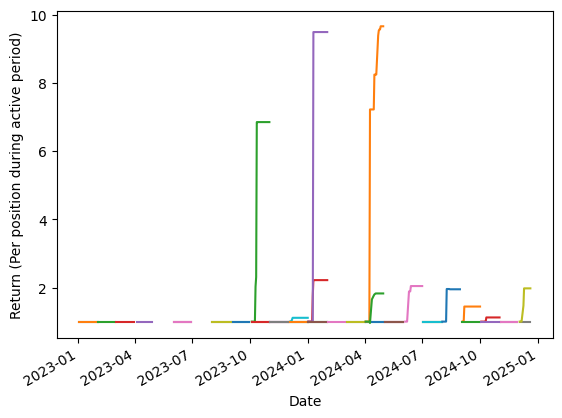

In [328]:
res_summary(res_it)
trade_plotter(res_it)

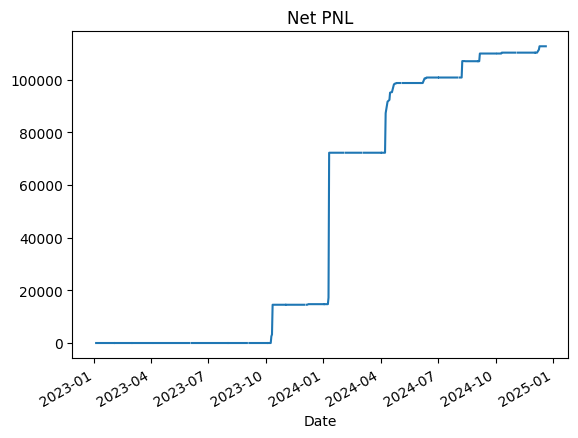

In [329]:
netPNLPlotter(res_it)

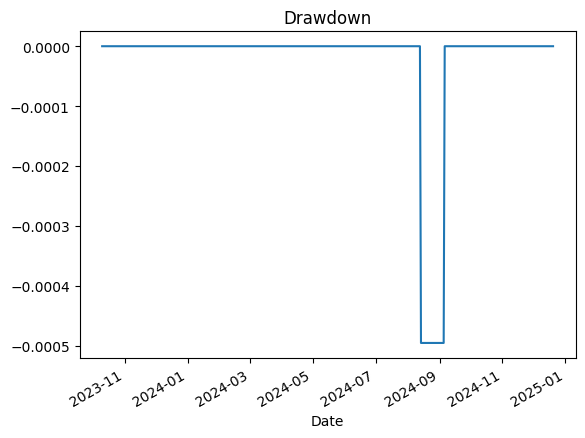

In [330]:
drawdownPlotter(res_it)

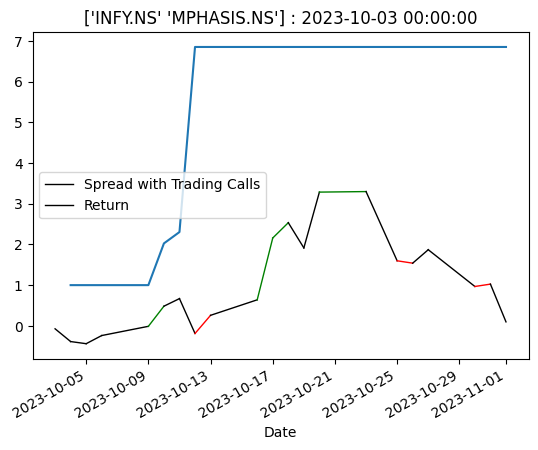

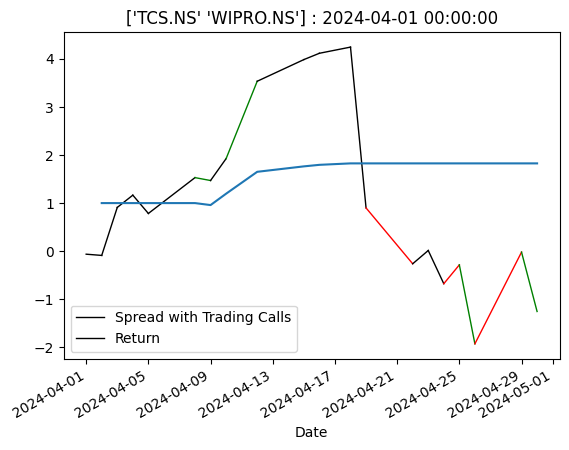

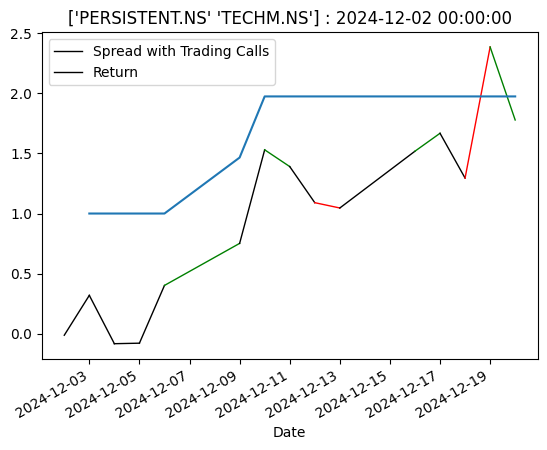

<Figure size 640x480 with 0 Axes>

In [331]:
trade_indicator(res_it)

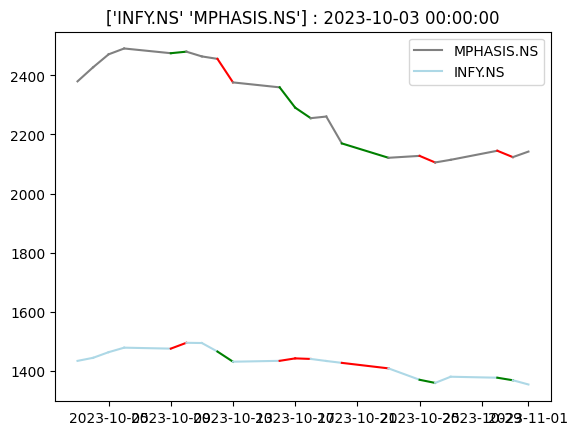

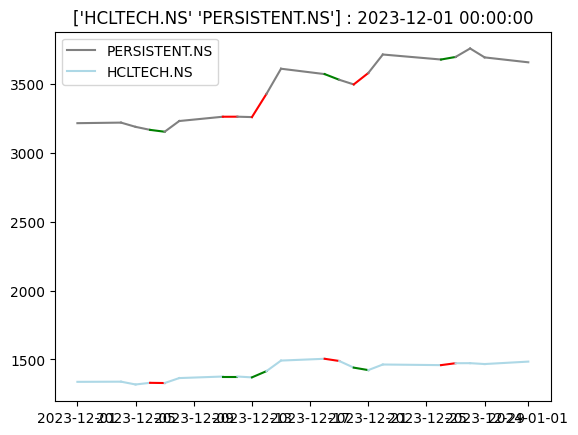

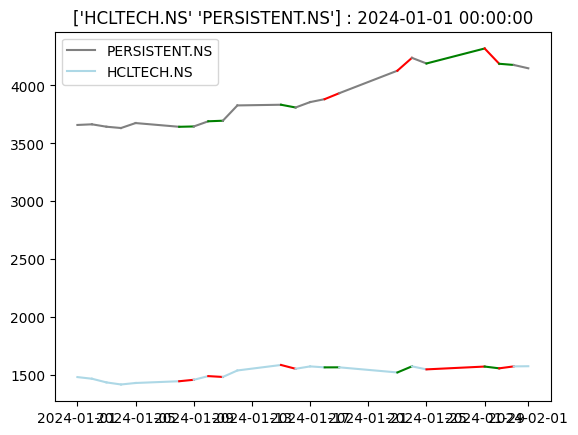

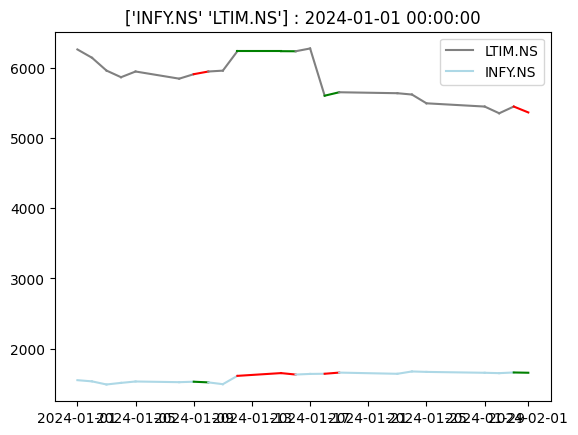

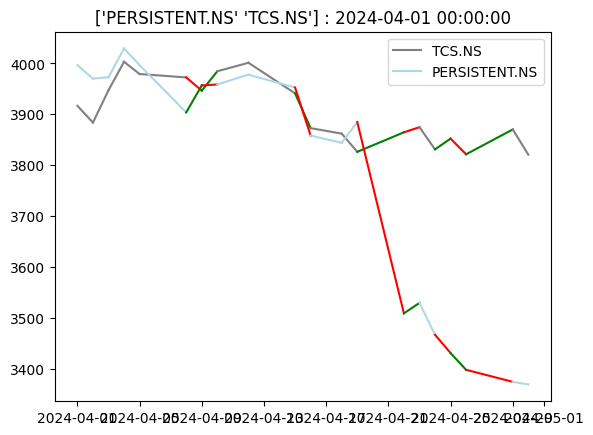

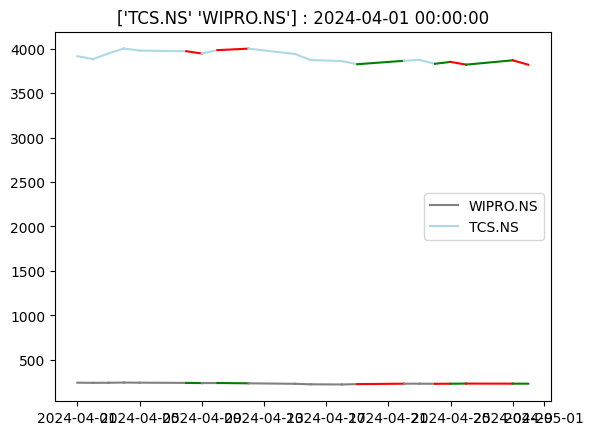

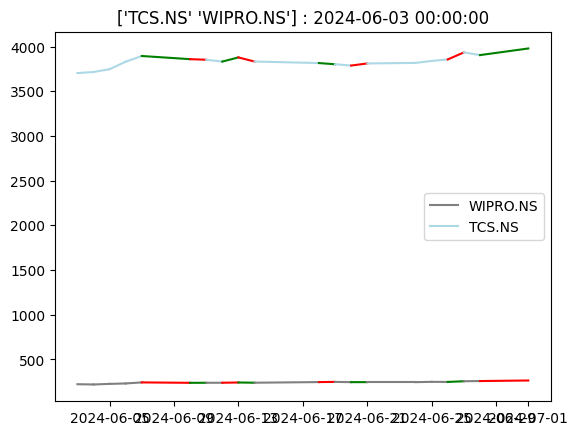

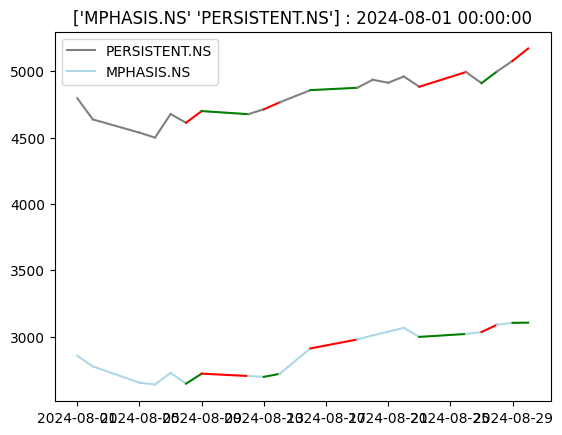

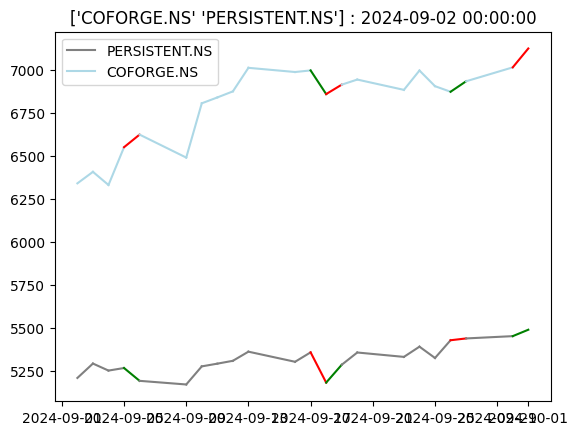

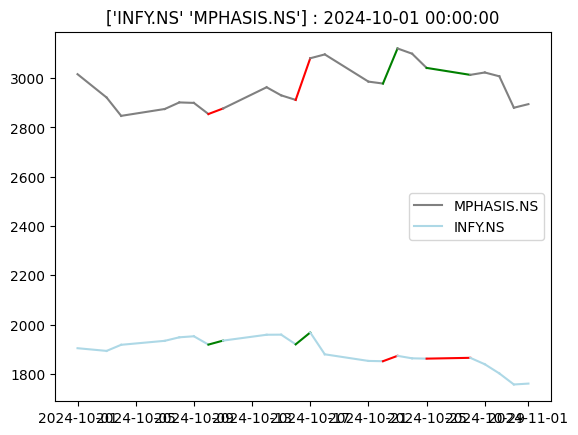

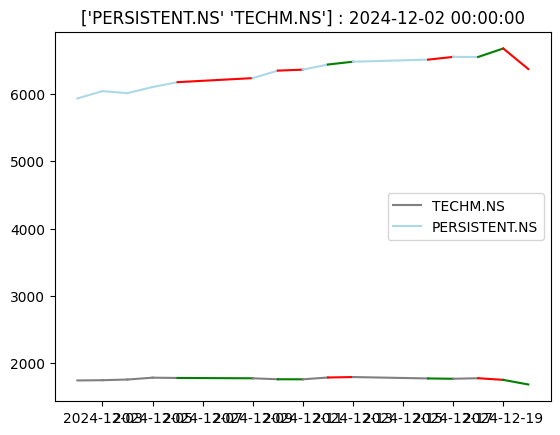

<Figure size 640x480 with 0 Axes>

In [332]:
spreadPriceTradePlot(res_it, plot_all=True)

In [333]:
df = pd.read_csv('pharma_train.csv', parse_dates=True, index_col='Date')

In [334]:
res_pharma = tester(df, start_date, end_date, allowed_drawdown, stop_loss, months_check_vol)

2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00


No. of profitable positions: 18, avg_profit = 4002.396703226992
No. of loss-making positions: 0, avg_loss = 0
No. of positions with no-change/no trading opportunities: 47
Net PnL = 72043.14065808586


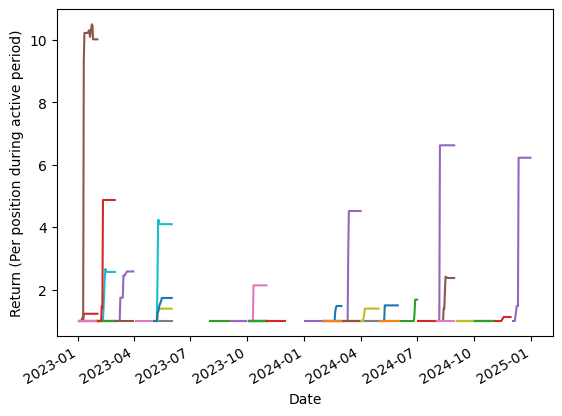

In [335]:
res_summary(res_pharma)
trade_plotter(res_pharma)

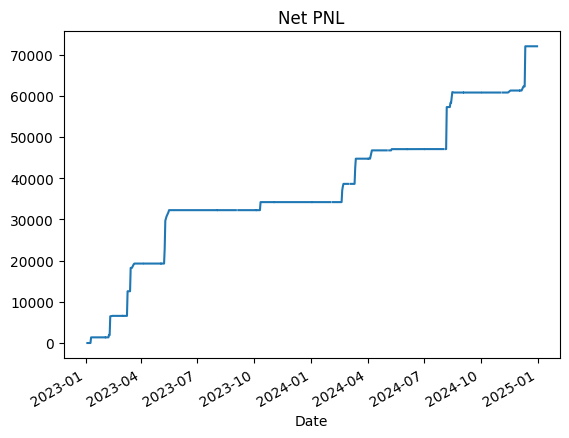

In [336]:
netPNLPlotter(res_pharma)

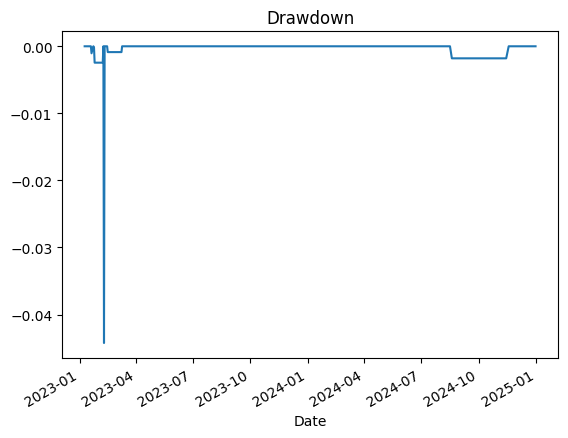

In [337]:
drawdownPlotter(res_pharma)

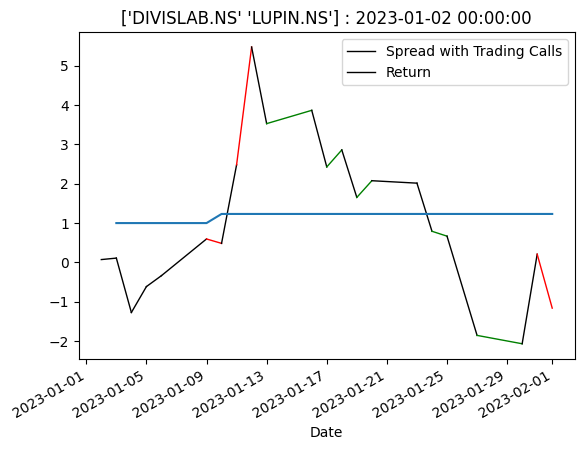

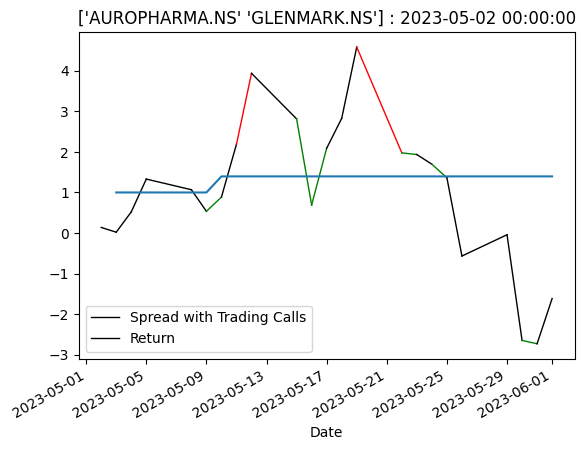

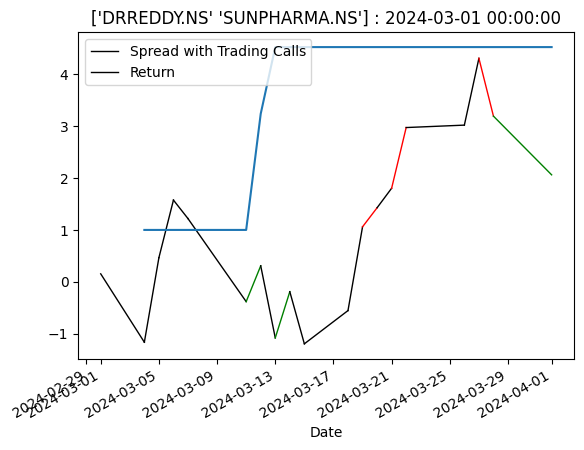

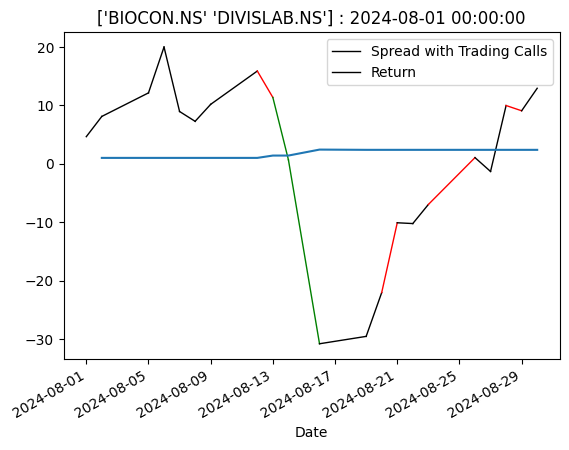

<Figure size 640x480 with 0 Axes>

In [338]:
trade_indicator(res_pharma)

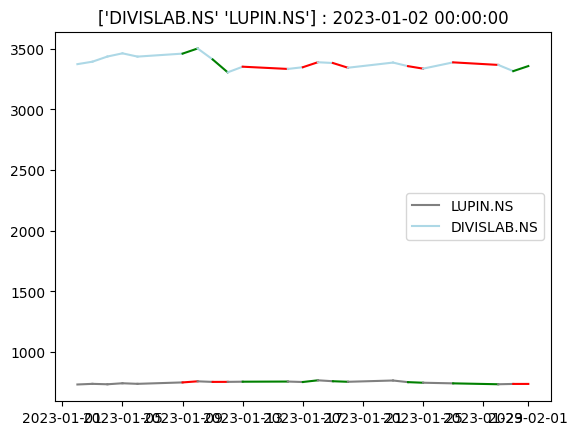

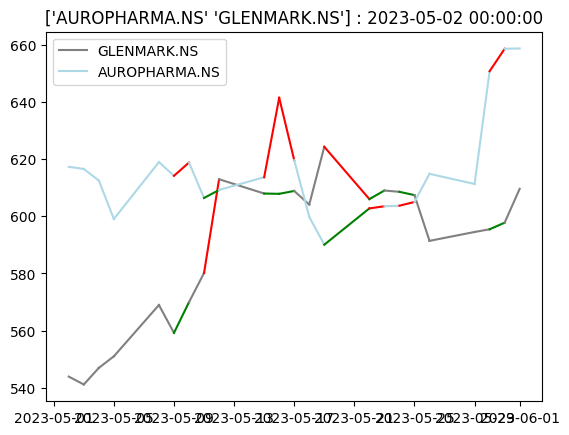

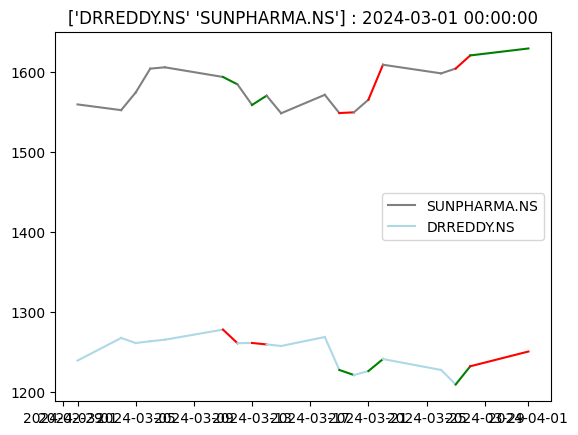

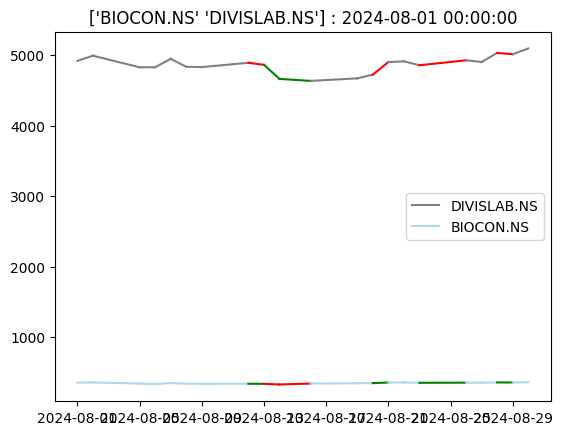

<Figure size 640x480 with 0 Axes>

In [339]:
spreadPriceTradePlot(res_pharma)